## Projeto Teste A/B

### Objetivo do Estudo:
O presente projeto visa analisar um teste A/B já iniciado. Será realizada uma análise exploratória dos dados e todo o teste será reavaliado para verificar a qualidade dos dados e a confiabilidade do teste. Ao final do projeto, serão descritas as conclusões e os principais resultados.

### Objetivo do experimento:
Testando mudanças relacionadas à introdução de uma recomendação do sistema melhorada

### Resultado esperado: 
Em até 14 dias após o cadastro, usuários mostram uma conversão melhor nas visualizações de página do produto (o evento `product_page` event), ao adicionar itens ao carrinho (`product_cart`), e compras (`purchase`). A cada etapa do funil `product_page → product_cart → purchase`, terá ao menos 10% de aumento.

### Importando as tabelas

In [292]:
# Importing the libraries
import pandas as pd
import os
from pathlib import Path
import plotly.graph_objects as go
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import to_hex
import numpy as np
import scipy.stats as st
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro

# Defining a default color palette for the plots
colors = sns.color_palette("Set2", n_colors=6)
my_palette = [to_hex(color) for color in colors]

`ab_project_marketing_events_us.csv`: o calendário de eventos de marketing para 2020  
`final_ab_new_users_upd_us.csv`: todos os usuários que se cadastraram na loja online de 7 a 21 de dezembro de 2020  
`final_ab_events_upd_us.csv`: todos os eventos dos novos usuários dentro do período de 7 de dezembro de 2020 até 1 de janeiro de 2021  
`final_ab_participants_upd_us.csv`: tabela contendo os participantes do teste

In [293]:
# Accessing the project directory
os.chdir('C:/Users/joaoq/My_projects/Projeto Final/E-Commerce-Identificar-os-perfis-dos-consumidores')

# Importing the data
df_mkt_events = pd.read_csv(Path('datasets/ab_project_marketing_events_us.txt'))
df_new_users = pd.read_csv(Path('datasets/final_ab_new_users_upd_us.txt'))
df_group_test = pd.read_csv(Path('datasets/final_ab_participants_upd_us.txt'))
df_new_events = pd.read_csv(Path('datasets/final_ab_events_upd_us.txt'))

### Analisando os dados - EDA

#### df_mkt_events

In [294]:
# Displays a summary of the DataFrame
df_mkt_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


In [295]:
# Display the first rows of the DataFrame
df_mkt_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [296]:
# Converting data types
df_mkt_events['start_dt'] = pd.to_datetime(df_mkt_events['start_dt'])
df_mkt_events['finish_dt'] = pd.to_datetime(df_mkt_events['finish_dt'])

In [297]:
# Removing duplicates
df_mkt_events.drop_duplicates(inplace=True)

Os dados do dataframe df_mkt_events foram limpos e convertidos. Não haviam dados faltantes para serem corrigidos.

#### df_new_users

In [298]:
# Displays a summary of the DataFrame
df_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [299]:
# Display the first rows of the DataFrame
df_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [300]:
# Counting the number of unique values in each column
df_new_users.nunique()

user_id       58703
first_date       17
region            4
device            4
dtype: int64

In [301]:
# Changing the data type
df_new_users['first_date'] = pd.to_datetime(df_new_users['first_date'])
df_new_users['region'] = df_new_users['region'].astype('category')
df_new_users['device'] = df_new_users['device'].astype('category')

In [302]:
# Removing the duplicated data
df_new_users.drop_duplicates(inplace=True)

Os dados do dataframe df_new_users foram limpos e convertidos. Não haviam dados faltantes para serem corrigidos.

#### df_group_test

In [303]:
# Displays a summary of the DataFrame
df_group_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [304]:
# Randomly sampling 5 rows from the dataframe
df_group_test.sample(5)

,user_id,group,ab_test
3799,4CF87C02B6E60013,B,interface_eu_test
13663,198FEF39910DCF76,B,interface_eu_test
7840,68624A9EC6B80373,B,interface_eu_test
6832,157B002B6AF06B2F,A,interface_eu_test
11987,69F2A9AA6DAEBF77,A,interface_eu_test


In [305]:
# Counting the number of unique values in each column
df_group_test.nunique()

user_id    13638
group          2
ab_test        2
dtype: int64

In [306]:
# Converting the columns to categorical data types
df_group_test['group'] = df_group_test['group'].astype('category')
df_group_test['ab_test'] = df_group_test['ab_test'].astype('category')

In [307]:
# Removing duplicated rows
df_group_test.drop_duplicates(inplace=True)

Os dados do dataframe df_group_test foram limpos e convertidos. Não haviam dados faltantes para serem corrigidos.

#### df_new_events

In [308]:
# Displays a summary of the DataFrame
df_new_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


In [309]:
# Randomly sampling 5 rows from the dataframe
df_new_events.sample(5)

,user_id,event_dt,event_name,details
292141,18D75308A1E687F0,2020-12-14 20:08:00,login,NaN
118418,A614BECBF35BC31C,2020-12-28 05:24:49,product_cart,NaN
292429,5DE1EE099A7261E4,2020-12-14 12:06:37,login,NaN
362390,7120241F086C338A,2020-12-21 05:07:18,login,NaN
12964,4CAAFB96E7DD55DB,2020-12-13 08:17:14,purchase,9.99


In [310]:
# Counting the number of unique values in each column
df_new_events.nunique()

user_id        58703
event_dt      257138
event_name         4
details            4
dtype: int64

In [311]:
# Converting the data types of the columns
df_new_events['event_dt'] = pd.to_datetime(df_new_events['event_dt'])
df_new_events['event_name'] = df_new_events['event_name'].astype('category')

In [312]:
# Removing the duplicated data
df_new_events.drop_duplicates(inplace=True)

In [313]:
# Counting the number of unique values for each event
df_new_events.groupby('event_name')['details'].nunique()

C:\Users\joaoq\AppData\Local\Temp\ipykernel_13624\614268240.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



event_name
login           0
product_cart    0
product_page    0
purchase        4
Name: details, dtype: int64

In [314]:
# Counting the occurrences of each unique value in the 'details' column for 'purchase' events
df_new_events[df_new_events['event_name'] == 'purchase'][['details']].value_counts()

details
4.99       44579
9.99        9158
99.99       5405
499.99      1172
Name: count, dtype: int64

In [315]:
# Creating a column for the date only
df_new_events['event_day'] = df_new_events['event_dt'].dt.date

# Converting to datetime
df_new_events['event_day'] = pd.to_datetime(df_new_events['event_day'])

In [316]:
# Viewing the data types
df_new_events.dtypes

user_id               object
event_dt      datetime64[ns]
event_name          category
details              float64
event_day     datetime64[ns]
dtype: object

No dataframe 'df_new_events' eliminamos os dados duplicados e convertemos os tipos de dados de cada coluna. Em relação aos dados faltantes da coluna 'details', ao visualizar os dados por evento, foi verificado que apenas os eventos de compra tinham dados, e que todas as linhas desse evento possui a informação, neste caso faz sentido não alterar nada, pois não teria o que preencher aqui.

#### Análise Exploratória dos dados

#### Analisando as premissas

- Possíveis registros de usuários criados após a data limite.
- Possíveis registros de eventos ocorridos após a data limite estabelecida.
- Público: 15% de novos usuários da região da UE
- Número esperado de participantes do teste: 6000

In [317]:
# Merging the experiment data table with the event data table
df_event_group = df_new_events.merge(df_group_test, on='user_id', how='left')
df_event_group = df_event_group.query("~group.isnull()")

In [318]:
# Analyzing event dates for test users
print(df_event_group['event_dt'].min())
print(df_event_group['event_dt'].max())

2020-12-07 00:02:48
2020-12-30 18:28:55


In [319]:
# Analyzing the first date of the new users
print(df_new_users['first_date'].min())
print(df_new_users['first_date'].max())

2020-12-07 00:00:00
2020-12-23 00:00:00


In [320]:
# Filter only data from the 'interface_eu_test' experiment
interface_eu_test = df_event_group[df_event_group['ab_test'] == 'interface_eu_test']

# Creating a set for users of this experiment
users_interface_eu_test = set(interface_eu_test['user_id'])

# Filter only data from the 'recommender_system_test' experiment
recommender_system_test = df_event_group[df_event_group['ab_test'] == 'recommender_system_test']

# Creating a set for users of this experiment
users_recommender_system_test = set(recommender_system_test['user_id'])

# Find users who are exclusive to 'interface_eu_test'
exclusive_interface_eu_test = users_interface_eu_test - users_recommender_system_test

In [321]:
# Extracting data exclusive to the second test
df_event_group = df_event_group[~df_event_group['user_id'].isin(exclusive_interface_eu_test)]

In [322]:
# Merging the events data with user information
df_event_group_user = df_event_group.merge(df_new_users, on='user_id', how='left')

In [323]:
# Visualizing data by region
df_event_group_user['region'].value_counts()

region
EU           28389
N.America      804
APAC           225
CIS            206
Name: count, dtype: int64

In [324]:
# Counting unique users from dataset
df_event_group_user['user_id'].nunique()

3675

Após uma primeira análise das premissas do teste, é possível tirar as seguintes conclusões para cada premissa:  

|                Premissa                 |Atendimento ou Não Atendimento|
|-----------------------------------------|----------------------|
| Data final de novos usuários: 21-12-2020| Premissa não atendida|
| Data de início: 07-12-2020              | Premissa atendida    |
| Data de término: 01-01-2021             | Premissa atendida    |
| Público: usuários da região da UE       | Premissa não atendida|
| Número esperado de participantes: 6000  | Premissa não atendida|


Ao não respeitar as premissas originais do teste, os resultados podem não se enquadrar perfeitamente nos objetivos que fizeram a equipe investir no teste, por exemplo: como o teste tinha a premissa de ser realizado com um público específico, utilizar participantes de outras regiões pode gerar um resultado que não corresponderá ao esperado para aquela região, ou ainda fazer com que decisões sejam tomadas a partir de resultados não representativos; outro exemplo seria o caso da quantidade de participantes, que por estarmos trabalhando com uma quantidade menor, pode comprometer a confiabilidade do experimento.

##### Conversão nas diferentes etapas do funil

In [325]:
# Grouping by event name and counting the number of users
events_grouped = df_new_events.groupby('event_name', as_index=False)['user_id'].count().sort_values('user_id', ascending=False)

# Creating a column for the previous step's user count
events_grouped["users_in_previous_step"] = events_grouped["user_id"].shift(1)

# Calculating the retention percentage from the previous step
events_grouped["conversion_previous_step"] = events_grouped["user_id"] / events_grouped["users_in_previous_step"]

# Viewing the table
events_grouped

C:\Users\joaoq\AppData\Local\Temp\ipykernel_13624\1822441127.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



,event_name,user_id,users_in_previous_step,conversion_previous_step
0,login,182465,NaN,NaN
2,product_page,120862,182465.0,0.662385
3,purchase,60314,120862.0,0.499032
1,product_cart,60120,60314.0,0.996783


In [326]:
# Creating the funnel chart
fig = go.Figure(go.Funnel(
    y = events_grouped['event_name'],
    x = events_grouped['user_id'],
    textinfo = "value+percent initial",
    marker = {"color": my_palette}
))

# Adjusting the title and displaying the chart
fig.update_layout(title="Funil de Vendas")
fig.show()

##### Verificando a distribuição de eventos por usuário para cada amostra

In [327]:
# Filtering events and users by sample A and B
df_A = df_event_group[df_event_group['group'] == 'A']
df_B = df_event_group[df_event_group['group'] == 'B']

In [328]:
# Counting the number of events per user
events_by_user_A = df_A.groupby('user_id',as_index=False, observed=True)['event_name'].nunique()
events_by_user_B = df_B.groupby('user_id',as_index=False, observed=True)['event_name'].nunique()

In [329]:
# Displaying descriptive statistics for the counting of events
print(events_by_user_A['event_name'].describe())
print()
print(events_by_user_B['event_name'].describe())

count    2863.000000
mean        2.256025
std         0.835392
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: event_name, dtype: float64

count    1253.000000
mean        2.146848
std         0.839795
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: event_name, dtype: float64


Text(0.5, 1.0, 'Distribution of Events per User')

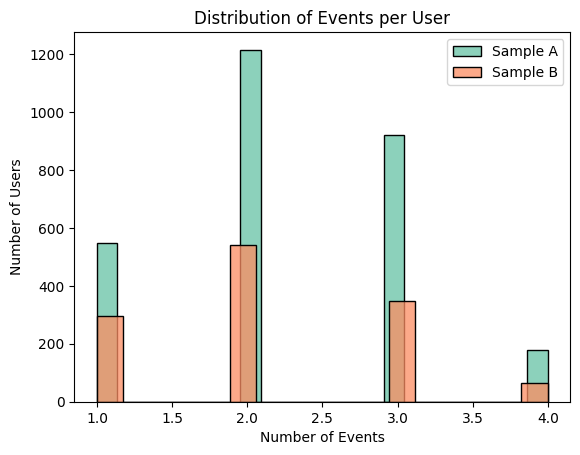

In [330]:
# Plotting histograms for the number of events per user in sample A and sample B
sns.histplot(events_by_user_A['event_name'], label='Sample A', color=colors[0])
sns.histplot(events_by_user_B['event_name'], label='Sample B', color=colors[1])

plt.xlabel('Number of Events')
plt.ylabel('Number of Users')
plt.legend()
plt.title('Distribution of Events per User')

Aqui, podemos ver com clareza que a distribuição dos eventos está bem semelhante nas duas amostras amostras, inclusive a semelhança se reflete nas principais métricas estatísticas. Uma questão que chama a atenção em uma primeira análise desses dados é a desproporção na quantidade de observações em cada amostra, mas veremos isso mais tarde.

##### Analisando se os mesmos usuários estão nas duas amostras

In [331]:
# Selecting user_ids for each sample and creating sets
users_sample_A = set(df_A['user_id'])
users_sample_B = set(df_B['user_id'])

In [332]:
# Finding the common users between sample A and sample B
common_users = users_sample_A.intersection(users_sample_B)

# Identifying users unique to sample A and users unique to sample B
unique_to_A = users_sample_A - users_sample_B
unique_to_B = users_sample_B - users_sample_A

# Printing the results
print(f"Usuários em comum: {len(common_users)}")
print(f"Usuários apenas na amostra A: {len(unique_to_A)}")
print(f"Usuários apenas na amostra B: {len(unique_to_B)}")

Usuários em comum: 441
Usuários apenas na amostra A: 2422
Usuários apenas na amostra B: 812


In [333]:
# Identifying the commom users to remove
common_users = pd.Series(list(common_users))

In [334]:
# Removing the common users
df_A = df_A[~df_A['user_id'].isin(common_users)]
df_B = df_B[~df_B['user_id'].isin(common_users)]

df_event_group = df_event_group[~df_event_group['user_id'].isin(common_users)]

In [335]:
# Repeating the process to visualize the results
users_sample_A = set(df_A['user_id'])
users_sample_B = set(df_B['user_id'])

common_users = users_sample_A.intersection(users_sample_B)

unique_to_A = users_sample_A - users_sample_B
unique_to_B = users_sample_B - users_sample_A

print(f"Usuários em comum: {len(common_users)}")
print(f"Usuários apenas na amostra A: {len(unique_to_A)}")
print(f"Usuários apenas na amostra B: {len(unique_to_B)}")

Usuários em comum: 0
Usuários apenas na amostra A: 2422
Usuários apenas na amostra B: 812


##### Distribuição dos eventos em cada dia

In [336]:
# Calculating the number of events per day for each sample
event_per_day_A = df_A.groupby('event_day',as_index=False)['event_name'].count()
event_per_day_B = df_B.groupby('event_day',as_index=False)['event_name'].count()

Text(0.5, 1.0, 'Distribution of Events per Date')

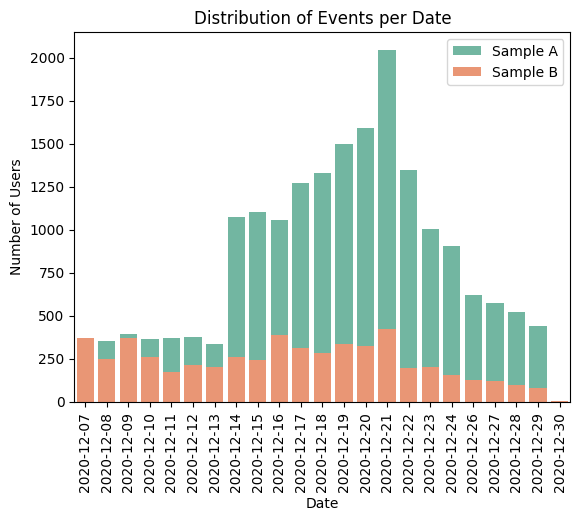

In [337]:
# Plotting the distribution of events per day
sns.barplot(x=event_per_day_A['event_day'], y=event_per_day_A['event_name'],  label='Sample A', color=colors[0])
sns.barplot(x=event_per_day_B['event_day'], y=event_per_day_B['event_name'], label='Sample B', color=colors[1])

plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Number of Users')
plt.legend()
plt.title('Distribution of Events per Date')

Neste último gráfico, podemos observar a distribuição de eventos por data, com isso fica mais claro as atividades dos usuários, por dia, do início ao fim do experimento. Vemos que os dois experimentos diferem bastante ao longo dos dias, com um certo pico de eventos entre os dias 14 e 24 de dezembro para o grupo controle, enquanto que o variante permanece sem esse crescimento, e decai depois de ser encerrado o período de cadastro de novos usuários.

#### Analisando a confiabilidade do experimento:

A seguir, vamos analisar a confiabilidade do experimento avaliando a proporção de algumas características relavantes que podem impactar as taxas de conversão e por conta disso devem ser proporcionais no grupo de controle e grupo variante:

- device: dispositivo usado para o cadastro. O dispositivo utilizado pode impactar a experiência do usuário e consequentemente a conversão
- region: Região do usuário. A região em que o usuário se localiza pode impactar a conversão por motivos econômicos.

Para avaliar se os dados são independentes será utilizado o teste de hipóteses qui-quadrado, este teste foi escolhido pois é teste ideal para avaliar distribuições de dados categóricos como esses.  

O nível de sigificância escolhido foi alpha = 0.05, e serão testadas as hipóteses:  
- Hipótese nula (H0): Não há uma diferença significativa nas proporções de usuários.  
- Hipótese alternativa (H1): Há uma diferença significativa nas proporções de usuários.

##### Verificando a distribuição da amostra em relação a região

In [338]:
# Merging the events data with user information
df_event_group_user = df_event_group.merge(df_new_users, on='user_id', how='left')

In [339]:
def distrib_graf(col_caract, col_group, col_user, df):
    """
    Creating a function to group the data by the specified characteristic and group columns, counting unique users, and creating a bar plot after that
    
    Parameters:
    - df: DataFrame containing the data
    - col_caract: Column name for the characteristic to analyze
    - col_group: Column name for the experiment group
    - col_user: Columns name for the user id
    """
    df_distrib = df.groupby([col_caract, col_group], as_index=False, observed=False)[col_user].nunique()

    # Creating a bar plot to visualize the distribution
    sns.barplot(data=df_distrib, x=col_caract, y=col_user, hue= col_group, palette=my_palette)
    plt.xlabel('Feature')
    plt.xticks(rotation=90)
    plt.ylabel('Number of Users')
    plt.legend()
    plt.title('Distribution of Events')

In [340]:
def qui2(df, col_caract, col_group, alpha=0.05):
    """
    Create a chi-squared test to determine if there is a significant difference
    in proportions between groups for a given characteristic.
    
    Parameters:
    - df: DataFrame containing the data
    - col_caract: Column name for the characteristic to analyze
    - col_group: Column name for the group to compare
    - alpha: Significance level for the test - default is 0.05
    """
    contingency_table = pd.crosstab(index=df[col_caract], columns=df[col_group])
    chi2, p, dof, expected = st.chi2_contingency(contingency_table)

    # Printing the results
    print("Tabela de Contingência:")
    print(contingency_table)
    print("P-Valor:", p)

    # Checking if the p-value is less than the alpha
    if p < alpha:
        print("\nRejeitamos a hipótese nula. Há uma diferença significativa nas proporções de usuários entre as regiões.")
    else:
        print("\nNão rejeitamos a hipótese nula. Não há uma diferença significativa nas proporções de usuários entre as regiões.")

C:\Users\joaoq\AppData\Local\Temp\ipykernel_13624\1125614784.py:14: UserWarning:

The palette list has more values (6) than needed (2), which may not be intended.



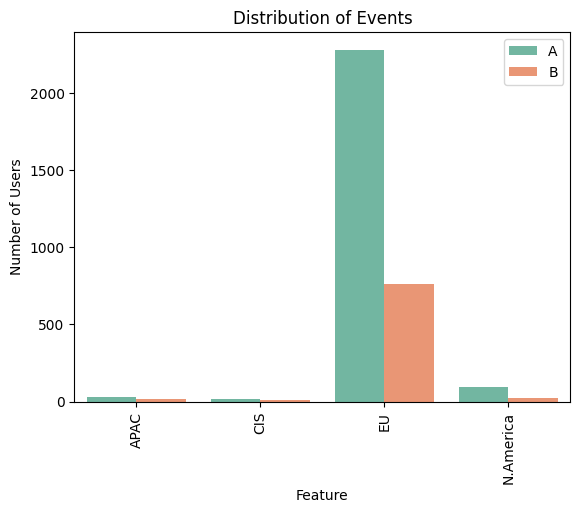

In [341]:
# Plotting the distribution of unique users by 'region'
distrib_graf('region','group','user_id',df_event_group_user)

In [342]:
# Performing thr chi-squared test to the distribution of users between 'region'
qui2(df_event_group_user,'region','group')

Tabela de Contingência:
group          A     B
region                
APAC         153    72
CIS          125    81
EU         17922  5085
N.America    679   125
P-Valor: 9.928610970847564e-15

Rejeitamos a hipótese nula. Há uma diferença significativa nas proporções de usuários entre as regiões.


##### Analisando se a proporção de cada amostra em relação ao dispositivo utilizado

C:\Users\joaoq\AppData\Local\Temp\ipykernel_13624\1125614784.py:14: UserWarning:

The palette list has more values (6) than needed (2), which may not be intended.



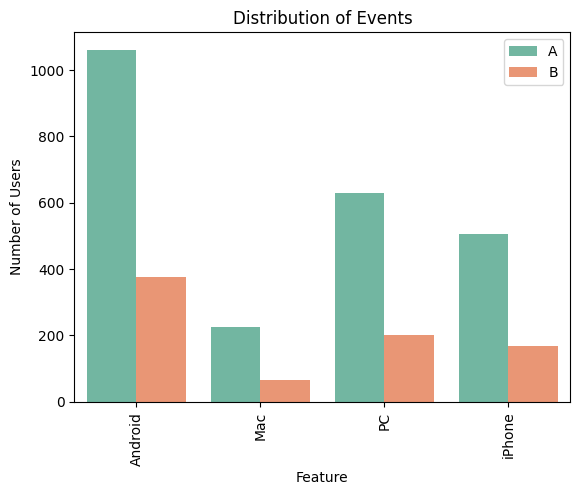

In [343]:
# Plotting the distribution of unique users by 'device'
distrib_graf('device','group','user_id',df_event_group_user)

In [344]:
# Performing thr chi-squared test to the distribution of users between 'device'
qui2(df_event_group_user,'device','group')

Tabela de Contingência:
group       A     B
device             
Android  8145  2457
Mac      1899   397
PC       4833  1309
iPhone   4002  1200
P-Valor: 2.503761449396059e-09

Rejeitamos a hipótese nula. Há uma diferença significativa nas proporções de usuários entre as regiões.


##### Analisando a distribuição dos dados em relação aos experimentos que os usuários de cada grupo participou

In [345]:
# Analisando a quantidade de usuários que participaram dos dois experimentos em cada grupo
both_exp_A = df_A.groupby('user_id', as_index=False)['ab_test'].nunique().query('ab_test > 1')
both_exp_B = df_B.groupby('user_id', as_index=False)['ab_test'].nunique().query('ab_test > 1')
print("Usuários do grupo controle que participaram dos dois experimentos: {}".format(len(both_exp_A)))
print("Usuários do grupo variante que participaram dos dois experimentos: {}".format(len(both_exp_B)))

Usuários do grupo controle que participaram dos dois experimentos: 340
Usuários do grupo variante que participaram dos dois experimentos: 106


In [346]:
# Calcular a proporção de usuários do segundo experimento em cada grupo do primeiro experimento
group_a_users = df_A[df_A['ab_test'] == 'recommender_system_test']
group_b_users = df_B[df_B['ab_test'] == 'recommender_system_test']

In [347]:
# Realizando um teste Z com esses valores
# Contagem direta de usuários envolvidos em ambos os experimentos para cada grupo
count_a = len(both_exp_A)
count_b = len(both_exp_B)

# Preparing data for the Z-test
count = [count_a, count_b]
nobs = [group_a_users.shape[0], group_b_users.shape[0]]

# Performing the Z-test for proportions
z_stat, p_value = proportions_ztest(count, nobs)

# Calculating the proportions for each group
prop_A = count_a / group_a_users.shape[0]
prop_B = count_b / group_b_users.shape[0]

In [348]:
# Printing the results
print(f"Proporção do teste 'interface_eu_test' no grupo A: {prop_A:.4f}")
print(f"Proporção do teste 'interface_eu_test' no grupo B: {prop_B:.4f}")
print(f"A variação na proporção dos testes da variante (B) em relação ao controle (A) foi: {((prop_B - prop_A)/prop_A):.2%}")
print(f"P-Valor: {p_value:.4f}")

# Interpreting the results
alpha = 0.05
if p_value < alpha:
    print("Rejeitamos a hipótese nula. Há uma diferença significativa na proporção do experimento 'interface_eu_test' entre os grupos.")
else:
    print("Não rejeitamos a hipótese nula. Não há uma diferença significativa na proporção entre os grupos.")

Proporção do teste 'interface_eu_test' no grupo A: 0.0205
Proporção do teste 'interface_eu_test' no grupo B: 0.0227
A variação na proporção dos testes da variante (B) em relação ao controle (A) foi: 10.44%
P-Valor: 0.3666
Não rejeitamos a hipótese nula. Não há uma diferença significativa na proporção entre os grupos.


Neste último tópico, analisamos a proporção de amostras do experimento 'interface_eu_test' por grupo A e B do experimento em questão (recommender system). Após separar os dados e analisar as proporções vimos que não houve diferença estatisticamente significativa na proporção do segundo experimento nos dois grupos do teste principal.

##### Particularidades dos dados

Em geral, observamos algumas questões importantes a respeito dos dados do experimento que vamos verificar a seguir: os dados parecem estar bem distribuidos em relação ao número de eventos por usuário, ou seja, foram encontratas quantidades semelhantes nas duas amostras, além disso, também se observou estatísticas próximas em relação ao número de eventos (média, quartis, etc.); em relação ao número de eventos por dia, vemos uma grande diferença nos dois grupos, principalmente no volume total por dia, mas também em relação ao movimento de pico no grupo A, que não se observou no grupo B.

Um fato que chamou a atenção e foi estatisticamente verificado é a proporção das características nos grupos como observado nos testes acima, pois apesar de a proporção de usuários participantes do segundo teste não serem estatisticamente diferentes nos dois grupos do teste principal, as distribuições entre as amostras não são independentes em relação a região do usuário e nem em relação ao dispositivo utilizado. E isso, por si só, já tornaria o experimento não totalmente confiável, pois essas desproporções podem comprometer os resultados do teste.

#### Avaliando os resultados do teste AB

Para analisar os resultados dos testes, vamos primeiro filtrar os eventos que ocorreram em até 14 dias após o cadastro do usuário que realizou a ação.

In [349]:
# Filtering date columns
df_event_group_user = df_event_group_user[df_event_group_user.apply(
    lambda row: row['event_day'] - row['first_date'] < pd.to_timedelta(14, unit='D'), axis=1)]

In [350]:
# Splitting filtered data into group A and B
df_A_filtered = df_event_group_user[df_event_group_user['group'] == 'A']
df_B_filtered = df_event_group_user[df_event_group_user['group'] == 'B']

##### Calculando a taxa de conversão dos dois grupos

In [351]:
# Grouping users in each experiment group by event, and counting the number of unique results
event_A = df_A_filtered.groupby('event_name')['user_id'].nunique()
event_B = df_B_filtered.groupby('event_name')['user_id'].nunique()

# Printing the results
print('Eventos do grupo controle:')
print(event_A)
print()
print('Eventos do grupo variante:')
print(event_B)

Eventos do grupo controle:
event_name
login           2422
product_cart     728
product_page    1571
purchase         773
Name: user_id, dtype: int64

Eventos do grupo variante:
event_name
login           811
product_cart    225
product_page    461
purchase        228
Name: user_id, dtype: int64


C:\Users\joaoq\AppData\Local\Temp\ipykernel_13624\3941279426.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\joaoq\AppData\Local\Temp\ipykernel_13624\3941279426.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [352]:
def z_value(event, alpha=0.05):
    '''
    Performs a Z-test to compare the proportions of a specific event.
    
    Parameters:
    - event: The name of the event.
    - alpha: Significance level for the test - default is 0.05.
    '''
    # Counting the number of unique users who performed the event in each group
    convert_A = df_A_filtered[df_A_filtered['event_name'] == event]['user_id'].nunique()
    convert_B = df_B_filtered[df_B_filtered['event_name'] == event]['user_id'].nunique()

    # Counting the total number of unique users in each group
    total_users_A = df_A_filtered['user_id'].nunique()
    total_users_B = df_B_filtered['user_id'].nunique()

    # Preparing data for the Z-test
    count = [convert_A, convert_B]
    nobs = [total_users_A, total_users_B]

    # Performing the Z-test for proportions
    z_stat, p_value = proportions_ztest(count, nobs)

    # Calculating the proportions for each group
    prop_A = convert_A / total_users_A
    prop_B = convert_B / total_users_B

    # Printing the results
    print(f"Proporção de conversão no grupo A: {prop_A:.4f}")
    print(f"Proporção de conversão no grupo B: {prop_B:.4f}")
    print(f"A variação na taxa de conversão da variante (B) em relação ao controle (A) foi: {((prop_B - prop_A)/prop_A):.2%}")
    print(f"P-Valor: {p_value:.4f}")

    # Interpreting the results
    if p_value < alpha:
        print("Rejeitamos a hipótese nula. Há uma diferença significativa na proporção de conversão entre os grupos.")
    else:
        print("Não rejeitamos a hipótese nula. Não há uma diferença significativa na proporção de conversão entre os grupos.")

In [353]:
# Getting a list of unique event from the DataFrame
eventos = ['product_page', 'product_cart', 'purchase']

# Looping through each event to perform the Z-test
for event in eventos:
    print('Evento:{}'.format(event))
    z_value(event)
    print()

Evento:product_page
Proporção de conversão no grupo A: 0.6486
Proporção de conversão no grupo B: 0.5677
A variação na taxa de conversão da variante (B) em relação ao controle (A) foi: -12.47%
P-Valor: 0.0000
Rejeitamos a hipótese nula. Há uma diferença significativa na proporção de conversão entre os grupos.

Evento:product_cart
Proporção de conversão no grupo A: 0.3006
Proporção de conversão no grupo B: 0.2771
A variação na taxa de conversão da variante (B) em relação ao controle (A) foi: -7.81%
P-Valor: 0.2040
Não rejeitamos a hipótese nula. Não há uma diferença significativa na proporção de conversão entre os grupos.

Evento:purchase
Proporção de conversão no grupo A: 0.3192
Proporção de conversão no grupo B: 0.2808
A variação na taxa de conversão da variante (B) em relação ao controle (A) foi: -12.02%
P-Valor: 0.0407
Rejeitamos a hipótese nula. Há uma diferença significativa na proporção de conversão entre os grupos.



Para os testes estatísticos acima, foi definido que seria utilizado o teste Z-test para avaliar se a diferença entre as proporções de conversão são ou não estatisticamente significativas, o teste foi escolhido pois vamos comparar apenas duas proporções simultaneamente, e também é mais comum de ser utilizada para comparar taxas de conversão.

O nível de sigificância escolhido foi novamente alpha = 0.05, e serão testadas as hipóteses:  
- Hipótese nula (H0): Não há uma diferença significativa nas proporções de conversão.  
- Hipótese alternativa (H1): Há uma diferença significativa nas proporções de conversão.

Analisando a proporção de conversões nos três eventos a serem analisados em cada grupo, podemos observar que no grupo variante houve uma conversão menor em relação ao grupo controle, o que indicaria um desempenho pior após as alterações na visualização das páginas.

##### Calculando o ticket médio das compras de cada grupo

In [354]:
# Filtering the DataFrames for 'purchase' events and selecting date and details
orders_value_A = df_A_filtered[df_A_filtered['event_name'] == 'purchase'][['event_day','details']]
orders_value_B = df_B_filtered[df_B_filtered['event_name'] == 'purchase'][['event_day','details']]

In [355]:
# Creating a column for cumulative values
orders_value_A['cumulative_sales'] = orders_value_A['details'].cumsum()
orders_value_B['cumulative_sales'] = orders_value_B['details'].cumsum()

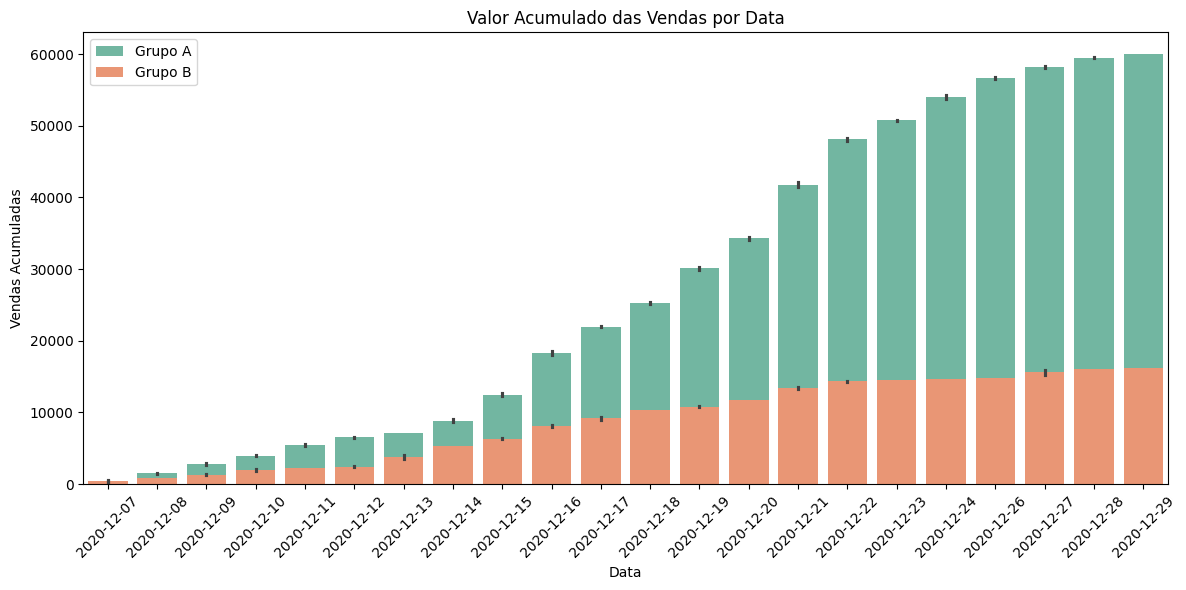

In [356]:
# Plotting a bar chart for the comulative values
plt.figure(figsize=(12, 6))
sns.barplot(data=orders_value_A, x='event_day', y='cumulative_sales', color= my_palette[0], label='Grupo A')
sns.barplot(data=orders_value_B, x='event_day', y='cumulative_sales', color= my_palette[1], label='Grupo B')
plt.xlabel('Data')
plt.ylabel('Vendas Acumuladas')
plt.title('Valor Acumulado das Vendas por Data')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

# Showing the chart
plt.show()

In [357]:
# Printing the average purchases
print('Ticket médio do grupo controle:', orders_value_A['details'].mean())
print('Ticket médio do grupo variante:', orders_value_B['details'].mean())

Ticket médio do grupo controle: 23.254398917665252
Ticket médio do grupo variante: 24.63176829268293


In [358]:
# Performing the Mann-Whitney test to compare the average ticket values
results = st.mannwhitneyu(orders_value_A['details'], orders_value_B['details'])

# Printing the p-value
print(f"P-Value: {results.pvalue:.4f}")

# Interpreting the results based on the p-value
alpha = 0.05
if results.pvalue < alpha:
    print("Rejeitamos a hipótese nula. Há uma diferença significativa no ticket médio dos grupos.")
else:
    print("Não rejeitamos a hipótese nula. Não há uma diferença significativa no ticket médio dos grupos.")

P-Value: 0.8184
Não rejeitamos a hipótese nula. Não há uma diferença significativa no ticket médio dos grupos.


O teste estatístico utilizado para a comparação dos ticket médios de cada grupo do experimento foi o teste Mann-Whitney U, pois os valores das compras não seguem distribuições normais.

O nível de sigificância escolhido foi alpha = 0.05, e serão testadas as hipóteses:  
- Hipótese nula (H0): Não há uma diferença significativa no ticket médio dos grupos.
- Hipótese alternativa (H1): Há uma diferença significativa no ticket médio dos grupos.

Através do teste acima, foi constatado que não há uma diferença significativa no ticket médio entre os grupos.

#### Conclusão Geral

Depois de todas as análises, podemos tirar as seguintes conclusões:

##### Resultado:
O resultado esperado era de uma conversão 10% maior em todas as etapas do funil, o que não ocorreu, foi identificado inclusive uma conversão menor no segundo grupo.

##### Avaliação geral sobre o teste
Após avaliar as premissas do teste, além de outros pontos que não foram bem monitorados na seleção das observações do experimento, como a quantidade de usuários no grupo A em relação ao grupo B, e as proporções de usuários distribuídos nas regiões e dispositivos utilizados serem estatísticamente enviesadas, podemos constatar que esses pontos nos permitem constatar que os resultados do experimento não são confiáveis.